In [5]:

import pandas as pd
import numpy as np
from datetime import datetime
import openpyxl

# Load the dataset from Excel
df = pd.read_excel('online_retail_II_all.xlsx', engine='openpyxl')

# Display initial information
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB
None
            Quantity                    InvoiceDate          Price  \
count  525461.000000                         525461  525461.000000   
mean       10.337667  2010-06-28 11:37:36.845017856       4.688834   
min     -9600.000000            2009-12-01 07:45:00  -53594.360000   
25%         1.000000   

In [6]:

# Check for missing values
print(df.isnull().sum())

# Remove rows with missing CustomerID
df = df.dropna(subset=['Customer ID'])

# Fill missing Description with 'Unknown'
df['Description'] = df['Description'].fillna('Unknown')



Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64


In [7]:

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Ensure CustomerID is integer
df['Customer ID'] = df['Customer ID'].astype(int)

# Convert Price to float
df['Price'] = df['Price'].astype(float)



In [8]:
# Remove duplicate entries
df.drop_duplicates(inplace=True)

In [9]:
# Function to remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from Quantity and Price
df = remove_outliers(df, 'Quantity')
df = remove_outliers(df, 'Price')

In [10]:
# Create TotalAmount column
df['TotalAmount'] = df['Quantity'] * df['Price']

# Extract date components
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek

In [11]:

import re

# Function to clean text
def clean_text(text):
    text = str(text).lower()
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    return text

# Apply text cleaning to Description
df['CleanDescription'] = df['Description'].apply(clean_text)



In [12]:

from sklearn.preprocessing import LabelEncoder

# Encode Country
le = LabelEncoder()
df['CountryEncoded'] = le.fit_transform(df['Country'])



In [13]:

# Check for any remaining issues
print(df.isnull().sum())
print(df.dtypes)

# Display sample of preprocessed data
print(df.head())



Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
Customer ID         0
Country             0
TotalAmount         0
Year                0
Month               0
Day                 0
DayOfWeek           0
CleanDescription    0
CountryEncoded      0
dtype: int64
Invoice                     object
StockCode                   object
Description                 object
Quantity                     int64
InvoiceDate         datetime64[ns]
Price                      float64
Customer ID                  int64
Country                     object
TotalAmount                float64
Year                         int32
Month                        int32
Day                          int32
DayOfWeek                    int32
CleanDescription            object
CountryEncoded               int64
dtype: object
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 2

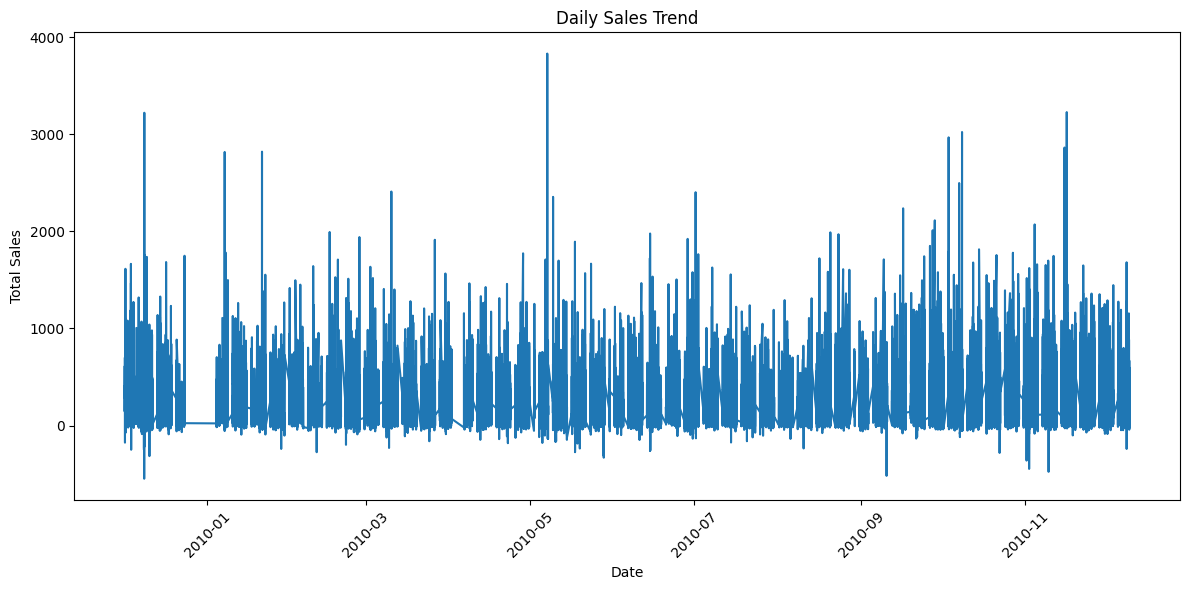

In [14]:
import matplotlib.pyplot as plt

# Aggregate daily sales
daily_sales = df.groupby('InvoiceDate')['TotalAmount'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(daily_sales['InvoiceDate'], daily_sales['TotalAmount'])
plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

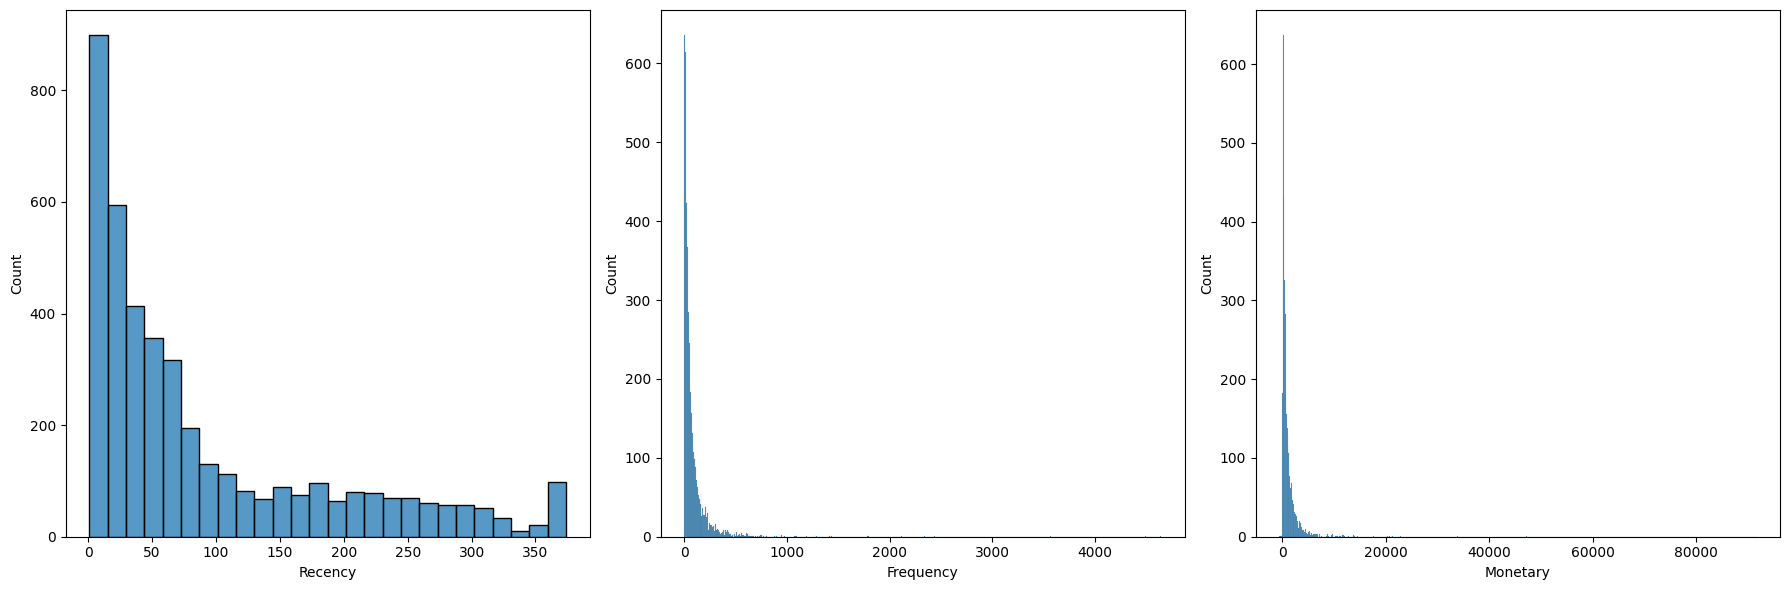

In [15]:
from datetime import datetime
import seaborn as sns
# Calculate RFM metrics
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'count',
    'TotalAmount': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Visualize RFM distribution
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
sns.histplot(data=rfm, x='Recency', ax=ax1)
sns.histplot(data=rfm, x='Frequency', ax=ax2)
sns.histplot(data=rfm, x='Monetary', ax=ax3)
plt.tight_layout()
plt.show()



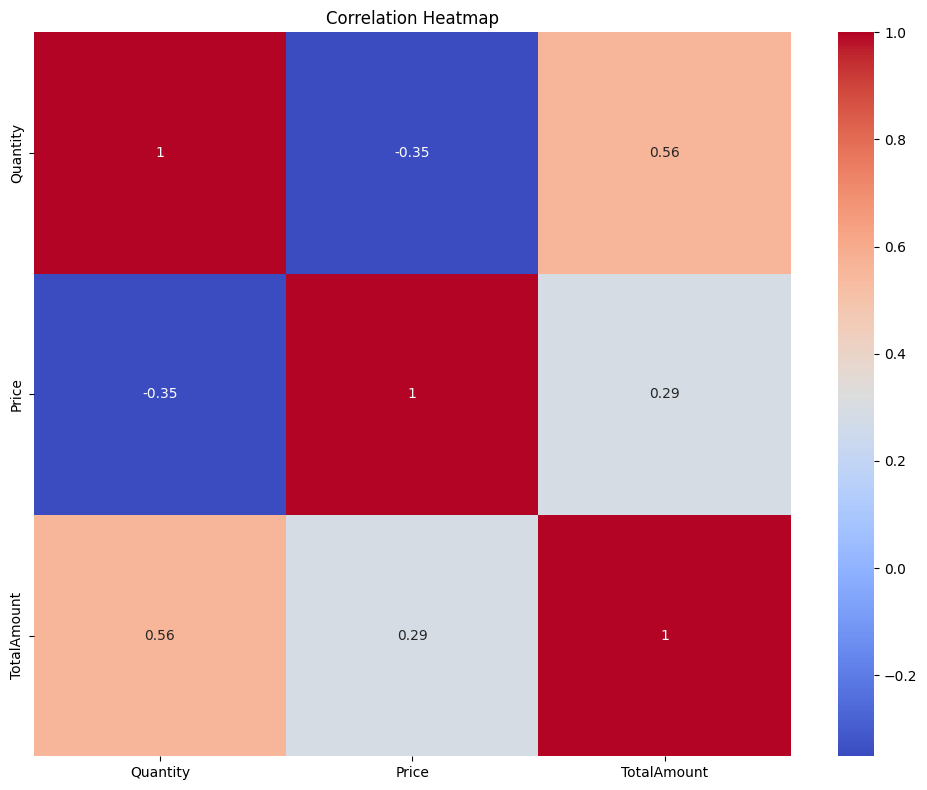

In [16]:
correlation_matrix = df[['Quantity', 'Price', 'TotalAmount']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()



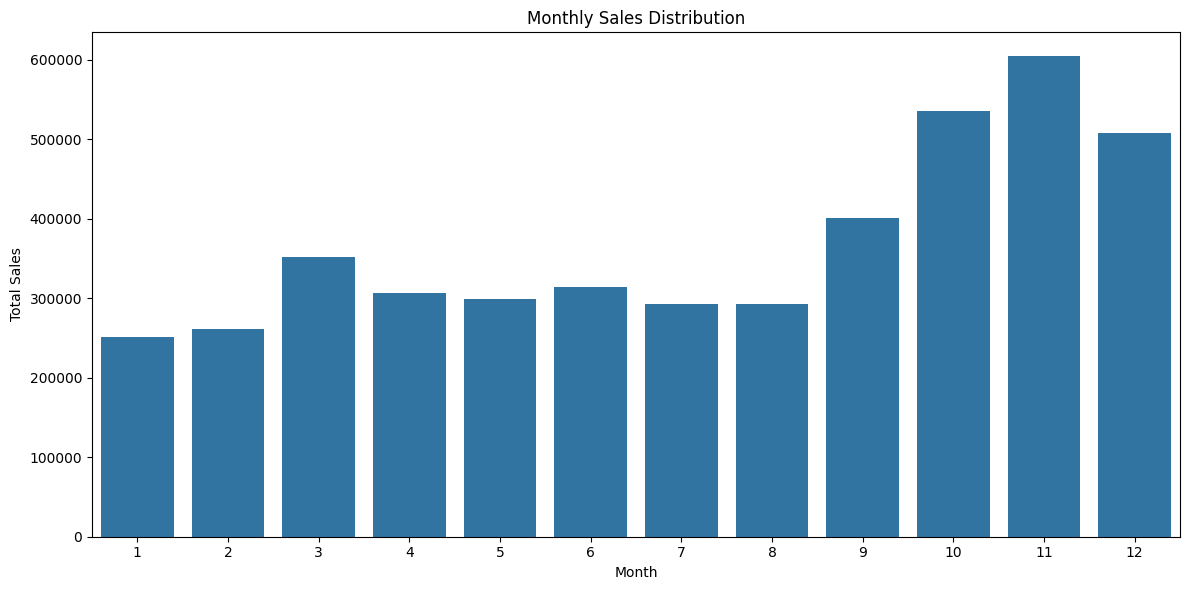

In [17]:
monthly_sales = df.groupby('Month')['TotalAmount'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='TotalAmount', data=monthly_sales)
plt.title('Monthly Sales Distribution')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()



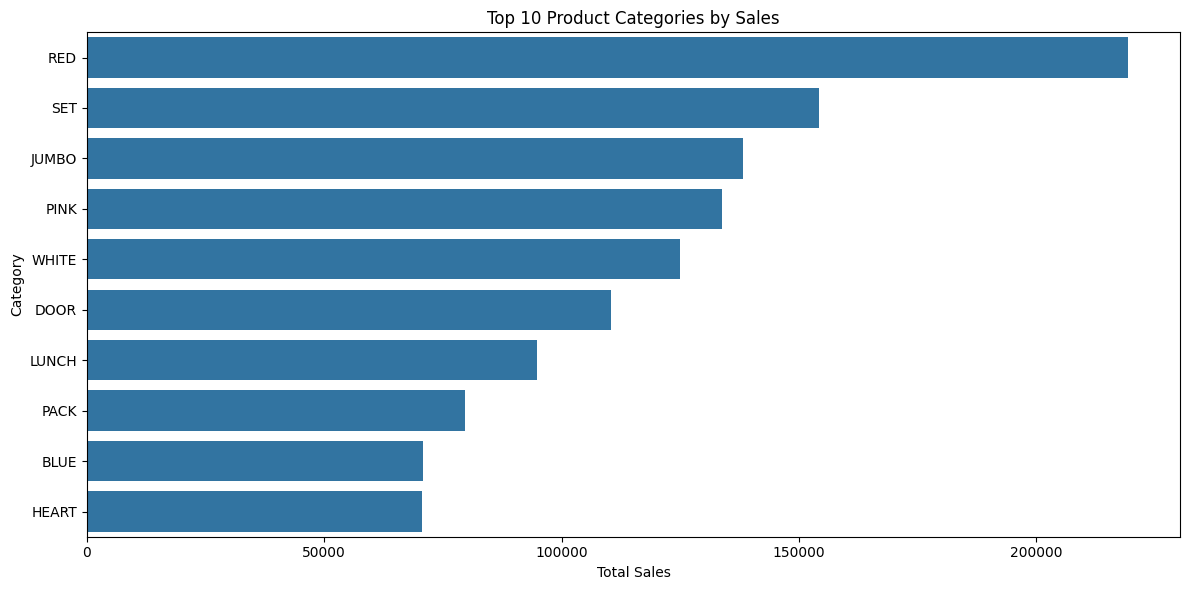

In [18]:
df['Category'] = df['Description'].apply(lambda x: x.split()[0])
category_sales = df.groupby('Category')['TotalAmount'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=category_sales.values, y=category_sales.index)
plt.title('Top 10 Product Categories by Sales')
plt.xlabel('Total Sales')
plt.tight_layout()
plt.show()

In [19]:
# Convert TotalAmount to numeric
df = df[pd.to_numeric(df['TotalAmount'], errors='coerce').notna()]
df['TotalAmount'] = pd.to_numeric(df['TotalAmount'])

# Create copy to avoid modifying original
X = df.copy()

# Handle datetime column
if pd.api.types.is_datetime64_any_dtype(X['InvoiceDate']):
    X['InvoiceDate_Year'] = X['InvoiceDate'].dt.year
    X['InvoiceDate_Month'] = X['InvoiceDate'].dt.month
    X['InvoiceDate_Day'] = X['InvoiceDate'].dt.day
    X['InvoiceDate_DayOfWeek'] = X['InvoiceDate'].dt.dayofweek
    X = X.drop('InvoiceDate', axis=1)

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Encode categorical columns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in categorical_cols:
    X[col] = le.fit_transform(X[col].astype(str))

# Prepare features and target
X = X.drop(['Customer ID'], axis=1)
y = X['TotalAmount']
X = X.drop(['TotalAmount'], axis=1)

# Changed to RandomForestRegressor for continuous target variable
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print(feature_importance)

                  feature    importance
3                Quantity  5.793298e-01
4                   Price  4.203235e-01
0                 Invoice  2.985492e-04
1               StockCode  1.618560e-05
12               Category  7.891147e-06
10       CleanDescription  5.759494e-06
2             Description  5.437005e-06
15        InvoiceDate_Day  2.704668e-06
8                     Day  2.357952e-06
16  InvoiceDate_DayOfWeek  1.872863e-06
7                   Month  1.704173e-06
14      InvoiceDate_Month  1.631386e-06
9               DayOfWeek  1.582577e-06
5                 Country  2.875496e-07
11         CountryEncoded  2.716335e-07
6                    Year  2.502105e-07
13       InvoiceDate_Year  1.725294e-07


In [20]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)  # Preserve 95% of variance
X_pca = pca.fit_transform(X_scaled)

print(f"Original features: {X.shape[1]}")
print(f"Features after PCA: {X_pca.shape[1]}")



Original features: 17
Features after PCA: 8


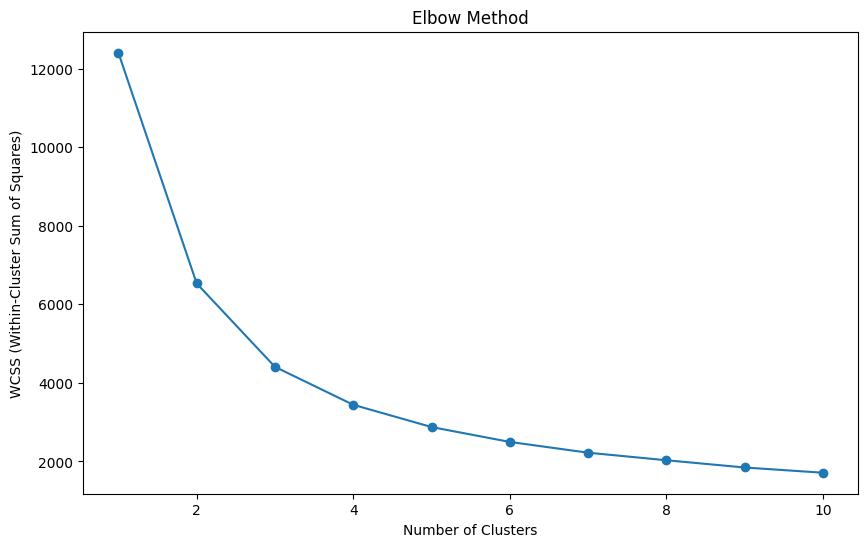

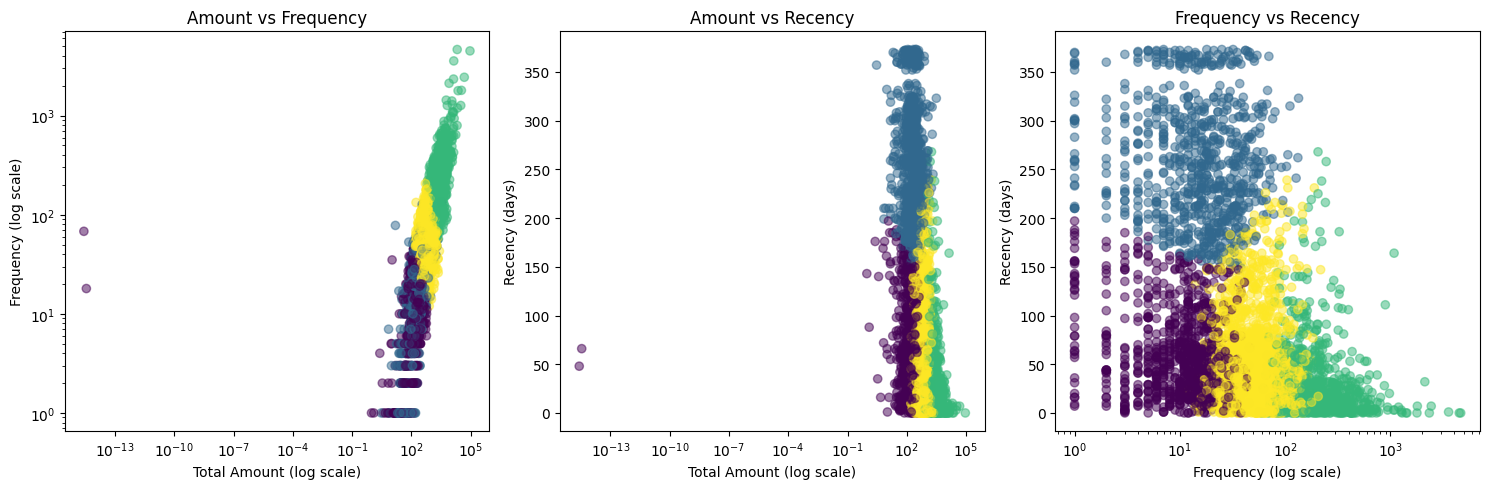


Cluster Analysis:
        TotalAmount                         Frequency               Recency  \
               mean     min       max count      mean   min     max    mean   
Cluster                                                                       
0            182.14    0.00    594.60   860     12.97   1.0    68.0   60.76   
1            273.69    2.95   3117.53   801     21.44   1.0   134.0  257.35   
2           3188.17  611.18  91609.84   925    251.90  57.0  4643.0   28.22   
3            706.70  157.72   2601.72  1550     56.44  12.0   217.0   52.25   

                   
         min  max  
Cluster            
0          0  197  
1        149  373  
2          0  268  
3          0  239  

Cluster Centers:
   TotalAmount   Frequency     Recency
0   145.243606   10.317050   60.735192
1   192.302383   15.362014  257.350811
2  2445.749837  193.486420   28.217768
3   622.584782   49.790340   52.227595


In [21]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_rfm_metrics(df):
    # Convert InvoiceDate to datetime if it isn't already
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    
    # Calculate Current Date (using max date in dataset)
    current_date = df['InvoiceDate'].max()
    
    # Calculate RFM metrics
    rfm = df.groupby('Customer ID').agg({
        'InvoiceDate': lambda x: (current_date - x.max()).days,  # Recency
        'Invoice': 'count',  # Frequency
        'TotalAmount': 'sum'  # Monetary
    }).rename(columns={
        'InvoiceDate': 'Recency',
        'Invoice': 'Frequency',
        'TotalAmount': 'TotalAmount'
    })
    
    # Remove any potential negative values in TotalAmount
    rfm = rfm[rfm['TotalAmount'] > 0]
    
    # Log transform TotalAmount and Frequency to handle skewed distributions
    rfm['TotalAmount'] = np.log1p(rfm['TotalAmount'])
    rfm['Frequency'] = np.log1p(rfm['Frequency'])
    
    return rfm

def perform_customer_segmentation(df, n_clusters=4):
    # Prepare data for clustering
    cluster_data = df[['TotalAmount', 'Frequency', 'Recency']]
    
    # Scale the features
    scaler = StandardScaler()
    cluster_data_scaled = scaler.fit_transform(cluster_data)
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    df['Cluster'] = kmeans.fit_predict(cluster_data_scaled)
    
    # Calculate cluster centers
    cluster_centers = pd.DataFrame(
        scaler.inverse_transform(kmeans.cluster_centers_),
        columns=['TotalAmount', 'Frequency', 'Recency']
    )
    
    # Transform cluster centers back from log scale
    cluster_centers['TotalAmount'] = np.expm1(cluster_centers['TotalAmount'])
    cluster_centers['Frequency'] = np.expm1(cluster_centers['Frequency'])
    
    return df, cluster_centers

def plot_elbow_curve(df):
    """
    Plot elbow curve to help determine optimal number of clusters
    """
    cluster_data = df[['TotalAmount', 'Frequency', 'Recency']]
    scaler = StandardScaler()
    cluster_data_scaled = scaler.fit_transform(cluster_data)
    
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(cluster_data_scaled)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
    plt.show()

def visualize_clusters(df):
    """
    Create visualizations of the customer segments
    """
    # Create a copy and inverse transform the logged values for visualization
    df_viz = df.copy()
    df_viz['TotalAmount'] = np.expm1(df_viz['TotalAmount'])
    df_viz['Frequency'] = np.expm1(df_viz['Frequency'])
    
    # Set up the matplotlib figure
    fig = plt.figure(figsize=(15, 5))
    
    # Plot 1: Amount vs Frequency
    plt.subplot(131)
    plt.scatter(df_viz['TotalAmount'], df_viz['Frequency'], c=df_viz['Cluster'], cmap='viridis', alpha=0.5)
    plt.xlabel('Total Amount (log scale)')
    plt.ylabel('Frequency (log scale)')
    plt.title('Amount vs Frequency')
    plt.xscale('log')
    plt.yscale('log')
    
    # Plot 2: Amount vs Recency
    plt.subplot(132)
    plt.scatter(df_viz['TotalAmount'], df_viz['Recency'], c=df_viz['Cluster'], cmap='viridis', alpha=0.5)
    plt.xlabel('Total Amount (log scale)')
    plt.ylabel('Recency (days)')
    plt.title('Amount vs Recency')
    plt.xscale('log')
    
    # Plot 3: Frequency vs Recency
    plt.subplot(133)
    plt.scatter(df_viz['Frequency'], df_viz['Recency'], c=df_viz['Cluster'], cmap='viridis', alpha=0.5)
    plt.xlabel('Frequency (log scale)')
    plt.ylabel('Recency (days)')
    plt.title('Frequency vs Recency')
    plt.xscale('log')
    
    plt.tight_layout()
    plt.show()

def analyze_clusters(df, cluster_centers):
    """
    Provide detailed analysis of each cluster
    """
    # Transform data back from log scale for analysis
    df_analysis = df.copy()
    df_analysis['TotalAmount'] = np.expm1(df_analysis['TotalAmount'])
    df_analysis['Frequency'] = np.expm1(df_analysis['Frequency'])
    
    # Calculate cluster characteristics
    cluster_analysis = df_analysis.groupby('Cluster').agg({
        'TotalAmount': ['mean', 'min', 'max', 'count'],
        'Frequency': ['mean', 'min', 'max'],
        'Recency': ['mean', 'min', 'max']
    }).round(2)
    
    return cluster_analysis

# Prepare RFM metrics
rfm_data = prepare_rfm_metrics(df)

# Plot elbow curve to determine optimal number of clusters
plot_elbow_curve(rfm_data)

# Perform clustering
segmented_customers, cluster_centers = perform_customer_segmentation(rfm_data, n_clusters=4)

# Visualize results
visualize_clusters(segmented_customers)

# Analyze clusters
cluster_analysis = analyze_clusters(segmented_customers, cluster_centers)
print("\nCluster Analysis:")
print(cluster_analysis)

# View cluster centers
print("\nCluster Centers:")
print(cluster_centers)

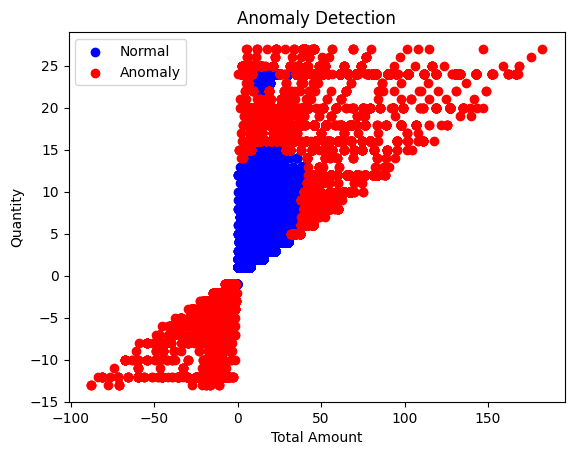

In [22]:
from sklearn.ensemble import IsolationForest

# Prepare data for anomaly detection
anomaly_data = df[['TotalAmount', 'Quantity']]

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
df['Anomaly'] = iso_forest.fit_predict(anomaly_data)

# Visualize anomalies
plt.scatter(df[df['Anomaly']==1]['TotalAmount'], df[df['Anomaly']==1]['Quantity'], c='blue', label='Normal')
plt.scatter(df[df['Anomaly']==-1]['TotalAmount'], df[df['Anomaly']==-1]['Quantity'], c='red', label='Anomaly')
plt.xlabel('Total Amount')
plt.ylabel('Quantity')
plt.title('Anomaly Detection')
plt.legend()
plt.show()

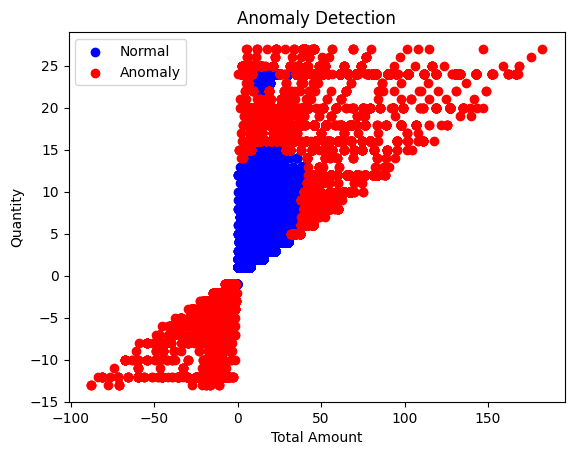

In [23]:
from sklearn.ensemble import IsolationForest

# Prepare data for anomaly detection
anomaly_data = df[['TotalAmount', 'Quantity']]

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
df['Anomaly'] = iso_forest.fit_predict(anomaly_data)

# Visualize anomalies
plt.scatter(df[df['Anomaly']==1]['TotalAmount'], df[df['Anomaly']==1]['Quantity'], c='blue', label='Normal')
plt.scatter(df[df['Anomaly']==-1]['TotalAmount'], df[df['Anomaly']==-1]['Quantity'], c='red', label='Anomaly')
plt.xlabel('Total Amount')
plt.ylabel('Quantity')
plt.title('Anomaly Detection')
plt.legend()
plt.show()



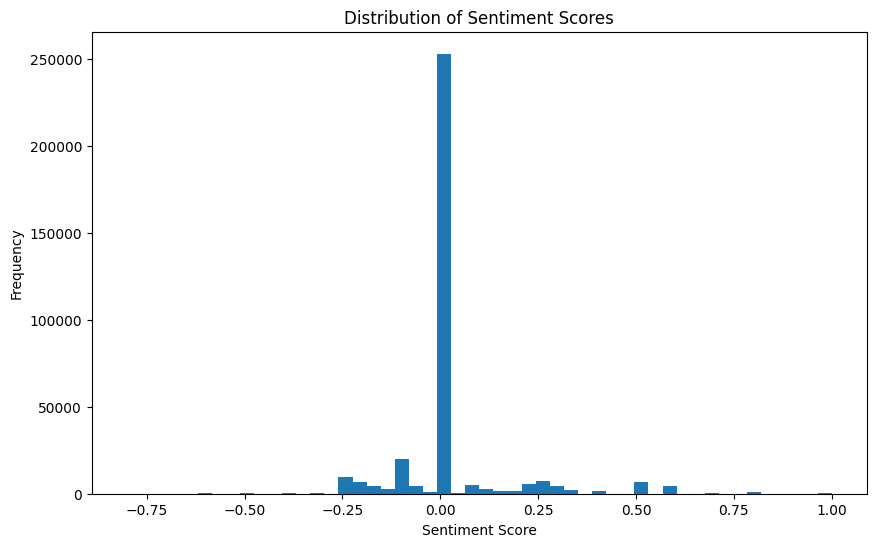

In [26]:

from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['Description'].apply(get_sentiment)

plt.figure(figsize=(10, 6))
plt.hist(df['sentiment'], bins=50)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

